In [1]:
# %load_ext autoreload
# %autoreload 2
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm
import argparse
import modules.A_mat as A_mat
import modules.pramameters as pramameters
import modules.plotGraph as plotGraph
import modules.utils as utils
import modules.nn as mynn
import modules.evaluate as evaluate
import pandas as pd


printFlag= 1
plotFlag= 1

#Changeable parameters 
parser = argparse.ArgumentParser(description='Topology fitting parameters')
pramameters.add_arguments(parser)
paras= pramameters.read_arguments(parser)
device= paras.device if torch.cuda.is_available() else "cpu"
#preset
paras.modelLoad= "AA"
paras.epoches= 20000
paras.epi= "ALL_"# Covid, H1N1, Sars, ALL
paras.strains= 1
if paras.epi== "ALL_":
    paras.strains = 3

# Read the CSV file into a NumPy array
epiOData = np.genfromtxt(f'testData/test_data.csv', delimiter=',', skip_header=0)
popData = np.genfromtxt(f'testData/test_pop.csv', delimiter=',', skip_header=0)
popIdxData = np.genfromtxt(f'testData/test_pop_inx.csv', delimiter=',', skip_header=0)
popIdxData= [int(i) for i in popIdxData]
pop_file_path = 'testData/Country_Population_final.csv'
data = pd.read_csv(pop_file_path)
popName= data["Country"].tolist()
popIdxAll= data["idx"]
popCropArea= data["CropArea"].to_numpy()
popCity= data["CityPop"].to_numpy()
popAll= data["CityPop"].to_numpy()
curPopName= [popName[int(i)] for i in popIdxData]
epiOData= np.array_split(epiOData, 3, axis=0)
epiOData= np.stack(epiOData, axis=1)
if paras.epi== "Sars_":
    epiOData= epiOData[:, 0:1, :]
elif paras.epi== "H1N1_":
    epiOData= epiOData[:, 1:2, :]
elif paras.epi== "Covid_":
    epiOData= epiOData[:, 2:3, :]
print("odata shape:", epiOData.shape)
popData= popAll[popIdxData]#/(popCropArea[popIdxData]/1e4+1e-9)
epiData= epiOData.copy()/popData[None, :]#[np.argmax(popData)]
epiData[1:, ...]= epiData[1:, ...]- epiData[:-1, ...]
epiData[epiData<0]= 0
epiData= epiData.T

mask= np.ones(epiData.shape)
mask= mask*popData[:, None, None]
print(popData.shape)
print(epiData.shape)
divide= torch.Tensor(epiData).to(device)
maskTensor= torch.Tensor(mask).to(device= device)
paras.n= divide.shape[0]
P= torch.Tensor(popData).to(device)

c:\Users\30678\.conda\envs\tf\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\30678\AppData\Roaming\Python\Python39\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


odata shape: (80, 3, 93)
(93,)
(93, 3, 80)


torch.Size([93, 3, 80])


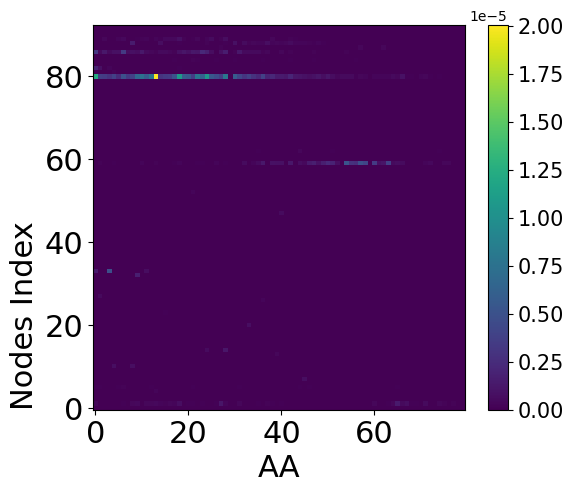

In [2]:
def rank_nodes_by_distance(G, source_node):
    # Get distances from the source_node to all other nodes
    distances = nx.single_source_shortest_path_length(G, source_node)
    # Sort nodes by distance from the source_node
    sorted_nodes = sorted(distances.items(), key=lambda x: x[1])
    # Return sorted nodes by their distance (excluding the distance values)
    return [node for node, _ in sorted_nodes]

print(divide.shape)

shapeY= divide.shape[0]
shapeX= divide.shape[2]
divide2D= (epiData[:, 0, :]).reshape(shapeY, shapeX)#.cpu().detach()
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
fontsize= 22
cmap= ax.pcolormesh(range(shapeX), range(shapeY), divide2D)
cbar= fig.colorbar(cmap)

cbar.ax.tick_params(labelsize= fontsize-7)

plt.ylabel("Nodes Index",  loc='bottom', fontsize= fontsize)

plt.xlabel(f"{paras.modelLoad}", fontsize= fontsize)

plt.gca().axes.get_xaxis().set_visible(True)

plt.gca().axes.get_yaxis().set_visible(True)

plt.tick_params(axis='both', labelsize=fontsize)

plt.show()

In [3]:
paras.seed= 1018#1, 10, 20, 30, 40, 50
torch.manual_seed(paras.seed)
timeHorizon= divide.shape[2]-1
if   paras.modelLoad=="AA":
    myMatch= mynn.matchingA(timeHorizon+1, paras.strains, paras.n, channel= 5,  device= device)
    myEpi= mynn.EpisA(input_dim= timeHorizon+1, num_heads= paras.strains, n= paras.n, device= device)
elif paras.modelLoad=="AsA":
    myMatch= mynn.matchingAs(timeHorizon+1, paras.strains, paras.n, channel= 5,  device= device)
    myEpi= mynn.EpisA(input_dim= timeHorizon+1, num_heads= paras.strains, n= paras.n, device= device)
elif paras.modelLoad=="AB":
    myMatch= mynn.matchingA(timeHorizon+1, paras.strains, paras.n, channel= 5,  device= device)
    myEpi= mynn.EpisB(input_dim= timeHorizon+1, num_heads= paras.strains, n= paras.n, device= device)
elif paras.modelLoad=="BA":
    myMatch= mynn.matchingB(timeHorizon+1, paras.strains, paras.n,  device= device)
    myEpi= mynn.EpisA(input_dim= timeHorizon+1, num_heads= paras.strains, n= paras.n, device= device)
elif paras.modelLoad=="BB":
    myMatch= mynn.matchingB(timeHorizon+1, paras.strains, paras.n,  device= device)
    myEpi= mynn.EpisB(input_dim= timeHorizon+1, num_heads= paras.strains, n= paras.n, device= device)
elif paras.modelLoad=="infer2018":
    myMatch= mynn.matchingB(timeHorizon+1, paras.strains, paras.n,  device= device)
    myEpi= mynn.EpisA(input_dim= timeHorizon+1, num_heads= paras.strains, n= paras.n, device= device)
    
optimizer1 = torch.optim.Adam(myMatch.parameters(),lr= 3e-4)#myMatch.parameters()
optimizer2 = torch.optim.Adam({myEpi.taus},lr= 3e-4)
optimizer3 = torch.optim.Adam({myEpi.R0dTaus},lr= 3e-4)
myloss= torch.nn.MSELoss(reduction='sum')
losses= []
predError= []
if paras.modelLoad in ["infer2018", "AB", "BB"]:
    threshold_value= 0.1
    hook = mynn.ThresholdHook(threshold_value)
    myEpi.taus.register_hook(hook)
    hook = mynn.ThresholdHook(threshold_value)
    myEpi.R0dTaus.register_hook(hook)
PreZs= []
maskDivide= maskTensor*divide
ratio= 1/(torch.norm(maskDivide.norm(dim= 2, keepdim= True), dim= 0, keepdim = True))

# r2= maskDivide[:, 2, :].sum()/maskDivide[:, 2, :].sum()
# r1= maskDivide[:, 2, :].sum()/maskDivide[:, 1, :].sum()
# r0= maskDivide[:, 2, :].sum()/maskDivide[:, 0, :].sum()
# ratio= torch.tensor([r0, r1, r2]).to(device=device)[None, :, None]/153

print(ratio.shape)
print(ratio)

Adj = np.genfromtxt('empirical_data/Flights_adj.csv', delimiter=',', skip_header= 0)
np.fill_diagonal(Adj, 0)
popIdxDataNp= np.array(popIdxData, dtype= "int")
AdjCur= Adj[ popIdxDataNp,:]
AdjCur= AdjCur[ :,popIdxDataNp]
AdjCurTen= torch.tensor(AdjCur, dtype= torch.float32).to(device)
MaskZ= (AdjCurTen>1e-9)*1.0

torch.Size([1, 3, 1])
tensor([[[7.5043e-04],
         [7.9224e-05],
         [8.0577e-06]]], device='cuda:0')


In [73]:
evaluateMeth= [evaluate.spectral_similarity, evaluate.pearson_correlation, evaluate.jaccard_similarity,evaluate.ROC_AUC, evaluate.PR_AUC]
for j in tqdm(range(paras.epoches*2)):
    optimizer1.zero_grad()  
    optimizer2.zero_grad()
    optimizer3.zero_grad()
    inferZmat= myMatch(divide, paras.modelLoad)
    predSignal, signal, PreZ= myEpi(divide, inferZmat)
    loss= myloss((predSignal*maskTensor*ratio)[:, :, 0:-1],(signal*maskTensor*ratio)[:, :, 1:])/100 + torch.var(myEpi.taus, dim= 0).sum()\
            + torch.var(myEpi.R0dTaus, dim= 0).sum()
    if torch.isnan(loss).any():
        utils.log_print(printFlag, f"meet nan value at {j}")#
        break
    errorTmp= myloss(predSignal[:, :, 0:-1] ,signal[:, :, 1:])
    losses.append(loss.item())
    predError.append(errorTmp.item())
    loss.backward(retain_graph=True)
    optimizer1.step()
    optimizer2.step()
    optimizer3.step()

100%|██████████| 40000/40000 [02:07<00:00, 313.38it/s]


torch.Size([93, 3, 80])
torch.Size([93, 3, 80])


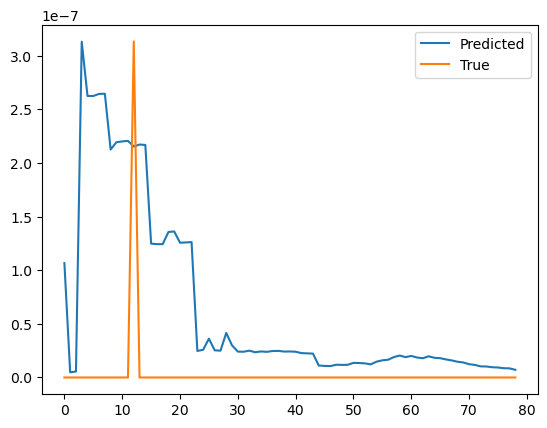

In [74]:
print(predSignal.shape)
print(signal.shape)
plt.plot(predSignal[4, 0, :-1].cpu().detach().numpy(), label= "Predicted")
plt.plot(signal[4, 0, 1:].cpu().detach().numpy(), label= "True")
plt.legend()

0.0028767582197677566


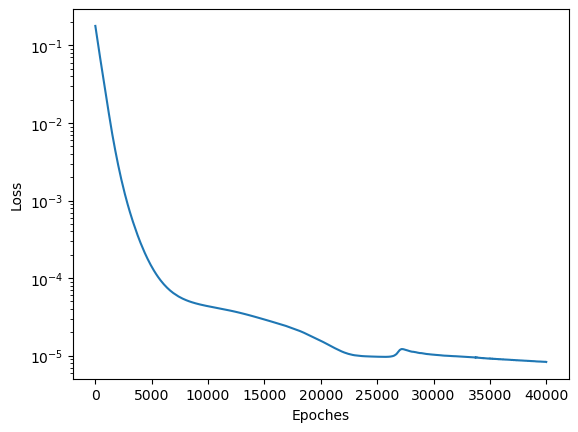

In [75]:
if plotFlag==1:
    plt.plot(predError)
    plt.yscale("log")
    plt.ylabel("Loss")
    plt.xlabel("Epoches")
print(np.sqrt(predError[-1]))

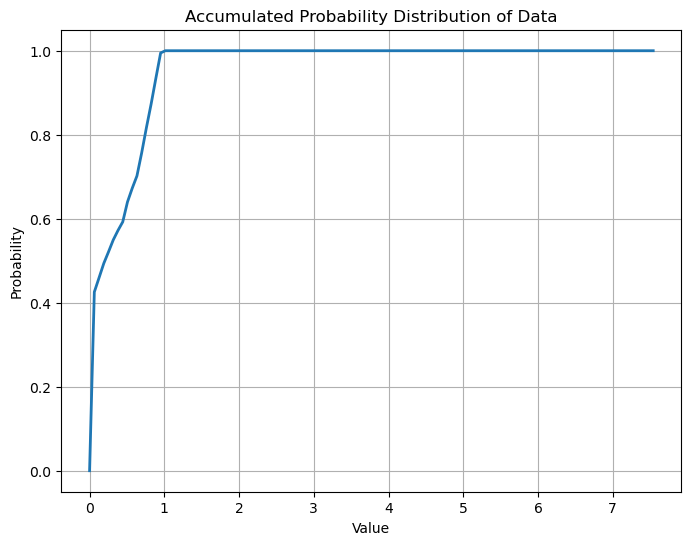

In [76]:
inferZmatNp= inferZmat.cpu().detach().numpy().squeeze()
pxs= []
pys= []
# Compute histogram
for i in range(120):
    px= i*(np.mean(inferZmatNp)-np.min(inferZmatNp))*3
    py= np.sum(inferZmatNp[inferZmatNp<px])/np.sum(inferZmatNp)
    pxs.append(px)
    pys.append(py)
    pass
# Plot the histogram as a probability distribution
plt.figure(figsize=(8, 6))
plt.plot(pxs, pys, linestyle='-', linewidth=2)
plt.xlabel('Value')
plt.ylabel('Probability')
plt.title('Accumulated Probability Distribution of Data')
plt.grid(True)
plt.show()

In [77]:
# #save: A, preA, losses, taus, pretaus, R0s, preR0s, [errors]
# utils.log_print(printFlag,1/(1.01+torch.abs(myEpi.taus)).T) # recoverry rate
# utils.log_print(printFlag,(myEpi.R0dTaus).T)# transmission rate
#H1N1:(0.1677, 0.1849), Sars: (0.1630, 0.1578), Covid: (0.1873, 0.3838)
IMatrix= torch.eye(paras.n, device= device)
# print(inferZmat)
PreA= A_mat.reverse_A_mat(inferZmat, P)
PreA= PreA*P
PreA= PreA/torch.norm(PreA)

utils.log_print(printFlag,torch.var(myEpi.taus, dim= 0))


tensor([3.1725e-05, 1.4999e-04, 2.0204e-02], device='cuda:0',
       grad_fn=<VarBackward0>)


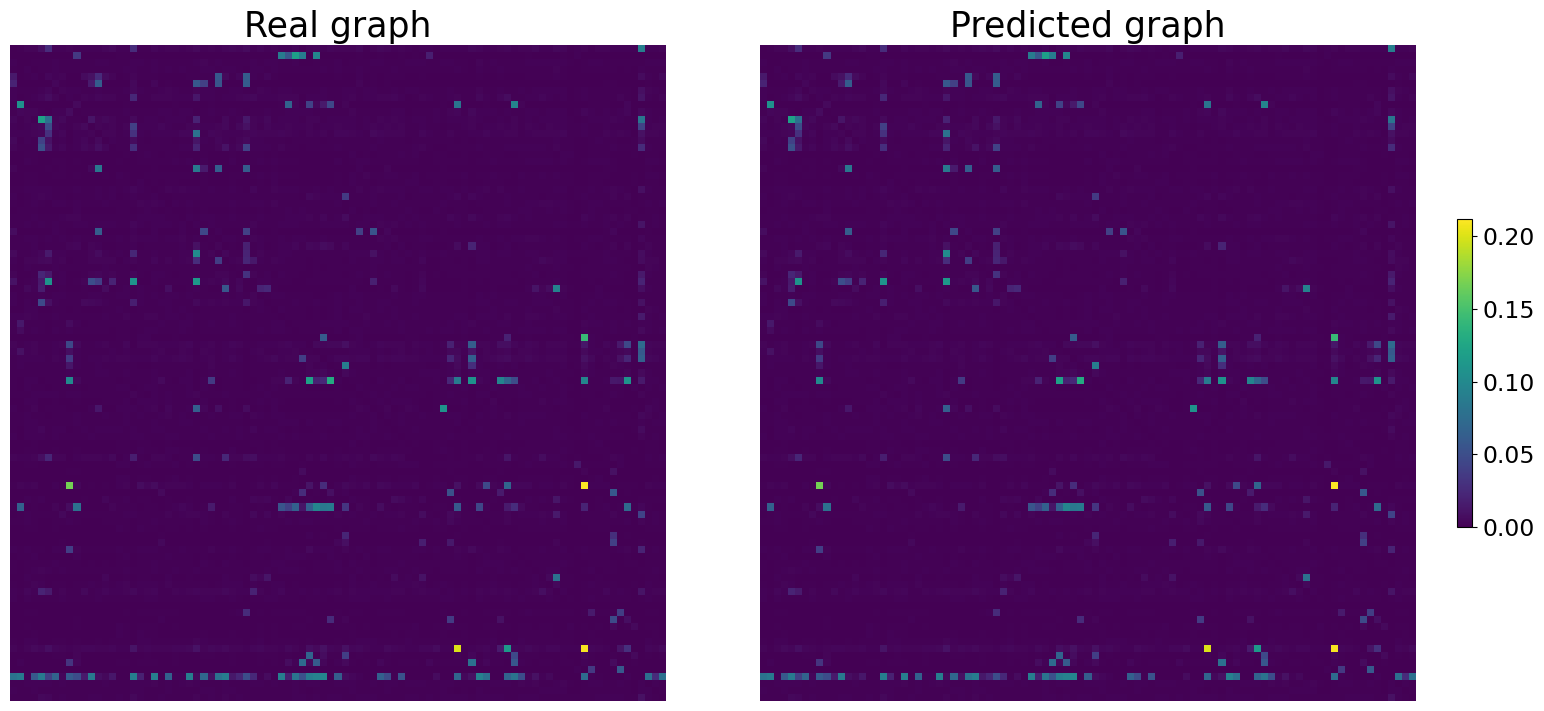

['Iceland', 'Canada', 'Algeria', 'Tunisia', 'Belgium', 'Germany', 'Estonia', 'Finland', 'United Kingdom', 'Netherlands', 'Ireland', 'Luxembourg', 'Norway', 'Poland', 'Sweden', 'South Africa', 'Cameroon', 'Spain', 'Morocco', 'Egypt', 'Bulgaria', 'Cyprus', 'Croatia', 'France', 'Greece', 'Hungary', 'Italy', 'Slovenia', 'Israel', 'Austria', 'Portugal', 'Bosnia and Herzegovina', 'Romania', 'Switzerland', 'Turkey', 'Moldova', 'Serbia', 'Slovakia', 'Dominican Republic', 'Guatemala', 'Honduras', 'Mexico', 'Nicaragua', 'Panama', 'Costa Rica', 'El Salvador', 'Cuba', 'New Zealand', 'Afghanistan', 'Bahrain', 'Saudi Arabia', 'Iran', 'Kuwait', 'Lebanon', 'United Arab Emirates', 'Oman', 'Pakistan', 'Iraq', 'Qatar', 'Taiwan', 'Japan', 'South Korea', 'Philippines', 'Argentina', 'Brazil', 'Chile', 'Ecuador', 'Paraguay', 'Colombia', 'Bolivia', 'Peru', 'Uruguay', 'Venezuela', 'Kazakhstan', 'Azerbaijan', 'Russia', 'Ukraine', 'Belarus', 'Uzbekistan', 'India', 'Hong Kong', 'Thailand', 'Vietnam', 'Indonesia',

In [78]:
toShowTopology= PreA
# print(inferZmat[0])
if plotFlag==1:
    plotGraph.plot_adjacenty(toShowTopology.cpu().detach().numpy(), [ toShowTopology.cpu().detach().numpy()])
sumDegree= toShowTopology.cpu().detach().numpy().sum(axis= 0)
rankedPreAdegree= np.argsort(sumDegree)
# print(rankedPreAdegree)
# print([curPopName[i] for i in rankedPreAdegree])
print(curPopName)

(93,)


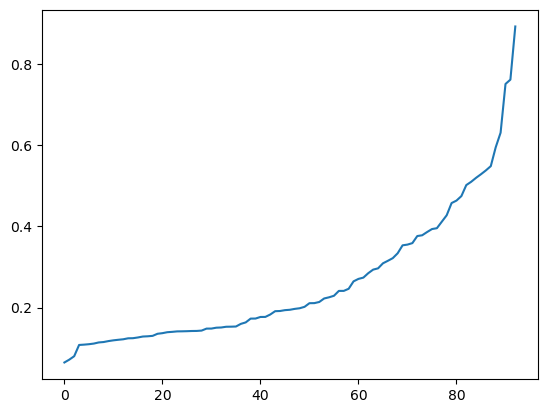

In [79]:
print(popData.shape)
plt.plot(sumDegree[rankedPreAdegree])

1
87
38
torch.Size([93, 3, 80])


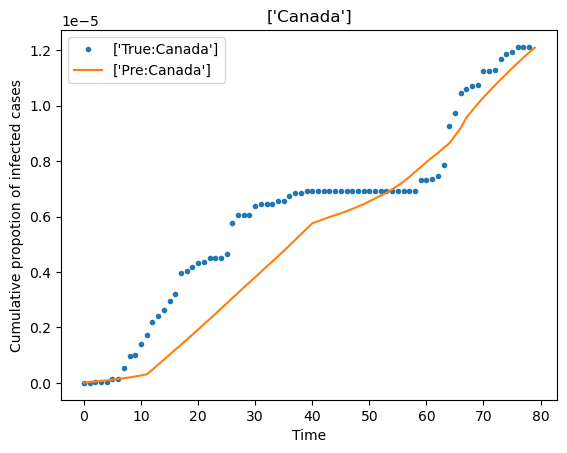

In [80]:
print(curPopName.index("Canada"))
print(curPopName.index("Australia"))
print(curPopName.index("Dominican Republic"))
if plotFlag==1:
    node= [1]# -28
    refEpi= np.cumsum(signal[node, 0, 1:].squeeze().T.cpu().detach().numpy(), axis= 0)
    preEpi= np.cumsum(predSignal[node, 0, 0:].squeeze().T.cpu().detach().numpy(), axis= 0)
    plt.plot(refEpi, ".", label=["True:"+curPopName[i] for i in node])
    plt.plot(preEpi, label= ["Pre:"+curPopName[i] for i in node])
    plt.title(f"{[curPopName[i] for i in node]}")
    plt.xlabel("Time")
    plt.ylabel("Cumulative propotion of infected cases")
    plt.legend()
    print(signal.shape)


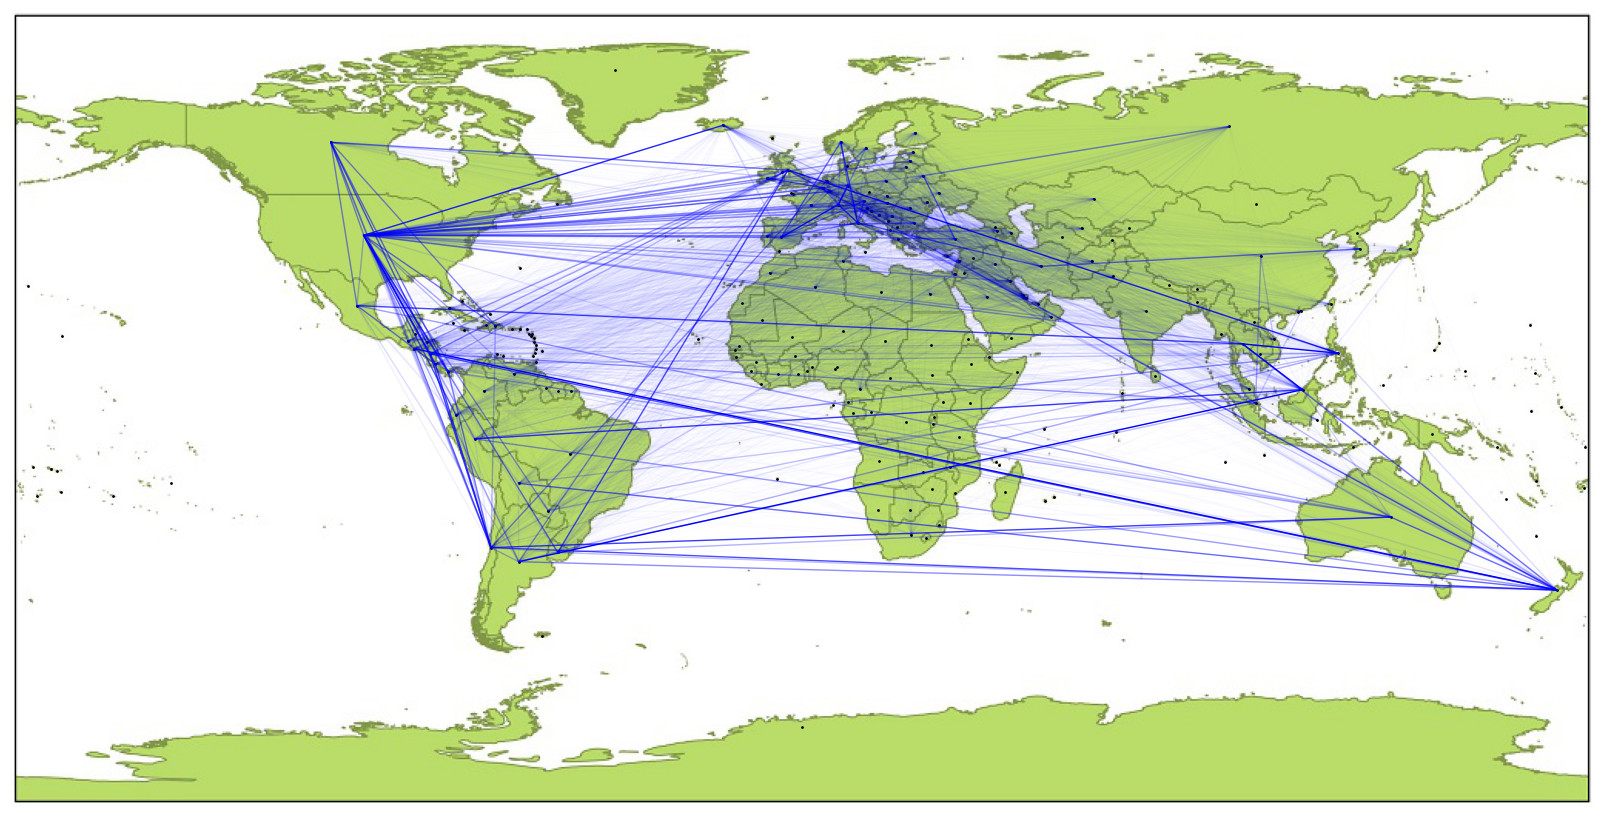

In [81]:
popIdxDataNp= np.array(popIdxData, dtype= "int")
def plot_on_map(PreANp, realNp, lineWeightRatio= 10):
    plt.figure(figsize=(10.28*2, 5.18*2))
    coordinatesArrayTmp= np.stack([data["loc_x"].to_numpy(), data["loc_y"].to_numpy()], axis= 1)
    img = plt.imread("WorldEqdc.jpg")
    plt.imshow(img)
    coordinatesArray= coordinatesArrayTmp.copy()
    coordinatesArray[:, 1]= 2.835*coordinatesArrayTmp[:, 1]+1028/2
    coordinatesArray[:, 0]= -2.835*coordinatesArrayTmp[:, 0]+518/2
    plt.scatter(coordinatesArray[:, 1], coordinatesArray[:, 0], color='black', s=1, label="Locations")
    # for i in range(len(popName)):
    #     plt.text(coordinatesArray[i, 1] + 0.1,
    #             coordinatesArray[i, 0] + 0.1, f"{popName[i]}", fontsize=10, color='black')  # Annotate points
    for i in range(realNp.shape[0]):
        for j in range(i + 1, realNp.shape[1]):  # Only upper triangle (undirected graph)
            if (realNp[j, i]+realNp[i, j])/2 > 1e-5 :# Only plot edges with weight > 0
                weight = (realNp[j, i]+realNp[i, j])/2
                plt.plot(
                    [coordinatesArray[popIdxDataNp[i], 1], coordinatesArray[popIdxDataNp[j], 1]],
                    [coordinatesArray[popIdxDataNp[i], 0], coordinatesArray[popIdxDataNp[j], 0]],
                    color='blue', alpha=min((weight)*lineWeightRatio, 1), linewidth= 1)
    for i in range(PreANp.shape[0]):
        for j in range(i + 1, PreANp.shape[1]):  # Only upper triangle (undirected graph)
            if (PreANp[j, i]+PreANp[i, j])/2 > 1e-5 :# Only plot edges with weight > 0
                weight = (PreANp[j, i]+PreANp[i, j])/2
                plt.plot(
                    [coordinatesArray[popIdxDataNp[i], 1], coordinatesArray[popIdxDataNp[j], 1]],
                    [coordinatesArray[popIdxDataNp[i], 0], coordinatesArray[popIdxDataNp[j], 0]],
                    color='orange', alpha=min((weight)*lineWeightRatio, 1), linewidth= 1)

    plt.axis('off')

portions= []
xs= []

TopNum= 50
APreNp= ((PreA)).cpu().detach().numpy()
rankedAPre= np.sort(APreNp.flatten())
ATrueNp= AdjCur/np.linalg.norm(AdjCur)
rankedATrue= np.sort(ATrueNp.flatten())
for TopNum in range(20, 1000):
    
    # print(((APreNp>rankedAPre[-TopNum])*APreNp).sum()/APreNp.sum())
    xs.append(((APreNp>rankedAPre[-TopNum])*APreNp).sum()/APreNp.sum())
    APreNpBi=  (APreNp>rankedAPre[-TopNum])*1.0
    # print(rankedAPre[-TopNum])
    ATrueNpBi= (ATrueNp>1e-9)*1.0
    # print(ATrueNp.sum()/(ATrueNp.shape[0]*ATrueNp.shape[1]))
    # print("portion:", ((APreNp*ATrueNp).sum())/APreNp.sum())
    portions.append(((APreNpBi*ATrueNpBi).sum())/APreNpBi.sum())
plot_on_map( 0*AdjCur/np.linalg.norm(AdjCur), PreA.cpu().detach().numpy(), 10)

Text(0, 0.5, 'Link Prediction accuracy')

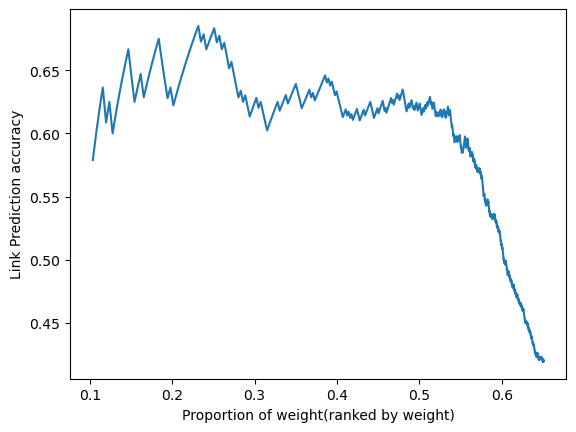

In [82]:
plt.plot(xs, portions)
plt.xlabel("Proportion of weight(ranked by weight)")
plt.ylabel("Link Prediction accuracy")

['India', 'Japan', 'Indonesia', 'Pakistan', 'South Korea', 'Egypt', 'Colombia', 'South Africa', 'Vietnam', 'Iraq', 'Bolivia', 'France', 'Venezuela', 'Morocco', 'Taiwan', 'Saudi Arabia', 'Kazakhstan', 'Cameroon', 'Malaysia', 'Brazil', 'Bosnia and Herzegovina', 'China', 'Slovakia', 'Lithuania', 'Afghanistan', 'Lebanon', 'Uzbekistan', 'Paraguay', 'Azerbaijan', 'Oman', 'Tunisia', 'Bahrain', 'Peru', 'Moldova', 'United Arab Emirates', 'Ukraine', 'Croatia', 'Algeria', 'Honduras', 'Kuwait', 'Guatemala', 'Cuba', 'Slovenia', 'Hong Kong', 'Dominican Republic', 'Latvia', 'Thailand', 'Greece', 'Netherlands', 'Hungary', 'Estonia', 'Bulgaria', 'Armenia', 'Cyprus', 'Russia', 'Israel', 'Argentina', 'Poland', 'Romania', 'Uruguay', 'Ecuador', 'Finland', 'Singapore', 'Serbia', 'El Salvador', 'Panama', 'Portugal', 'Belarus', 'Mexico', 'Belgium', 'Italy', 'Iran', 'Qatar', 'Austria', 'Luxembourg', 'Turkey', 'Sweden', 'Spain', 'Norway', 'Germany', 'Iceland', 'Australia', 'Costa Rica', 'Nicaragua', 'Ireland', 

Text(0, 0.5, 'In-degree')

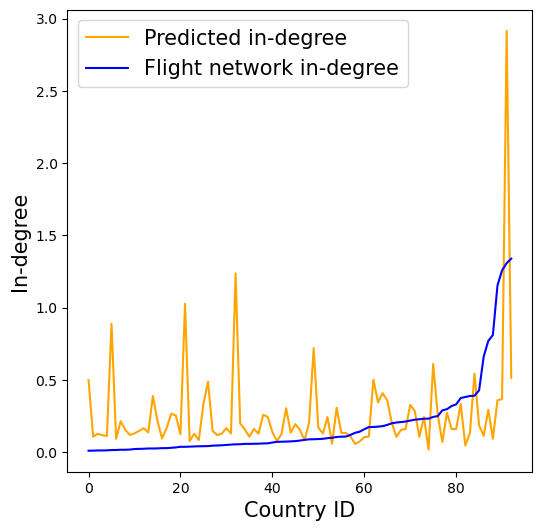

In [83]:
plt.figure(figsize=(6, 6))
PreADegree= PreA.sum(axis= 1).cpu().detach().numpy()
rankedPreAdegree= np.argsort(PreADegree)

Adj = np.genfromtxt('empirical_data/Flights_adj.csv', delimiter=',', skip_header= 0)
np.fill_diagonal(Adj, 0)
AdjCur= Adj[ popIdxDataNp,:]
AdjCur= AdjCur[ :,popIdxDataNp]
AdjCurTen= torch.tensor(AdjCur, dtype= torch.float32).to(device)
# AdjCurTen2= AdjCurTen.to(torch.float32)
# AdjCurTen2= A_mat.reverse_A_mat(AdjCurTen2/P, P)*P
AdjCurTen2= AdjCurTen/torch.norm(AdjCurTen)

AdjCurTenDegree= AdjCurTen2.sum(axis= 1).cpu().detach().numpy()
rankedAdjCurdegree= np.argsort(AdjCurTenDegree)

print(print([curPopName[i] for i in rankedPreAdegree]))
print(print([curPopName[i] for i in rankedAdjCurdegree]))

plt.plot(PreADegree[rankedAdjCurdegree], color= "orange", label= "Predicted in-degree")
plt.plot(AdjCurTenDegree[rankedAdjCurdegree], color= "blue", label= "Flight network in-degree")
plt.legend(fontsize= 15)
plt.xlabel("Country ID", fontsize= 15)
plt.ylabel("In-degree", fontsize= 15)

In [84]:
randA= torch.rand((paras.n, paras.n)).to(device)
randA= randA/torch.norm(randA)
focuCountry= 88
# for focuCountry in range(PreA.shape[1]):
#     # print(evaluate.spectral_similarity(PreA[:, focuCountry], AdjCurTen2[:, focuCountry]))
#     pearsonRes= evaluate.pearson_correlation(PreA[:, focuCountry], AdjCurTen2[:, focuCountry]).item()
#     if pearsonRes>0.2:
#         print(pearsonRes)
#         print(curPopName[focuCountry])
PearsonRankedScores= []
for TrustDegree in range(20, 1000):
    tmpScore= evaluate.pearson_correlation(PreA*(PreA>rankedAPre[-TrustDegree]), AdjCurTen2*(PreA>rankedAPre[-TrustDegree]))
    PearsonRankedScores.append(tmpScore.item())
TrustDegree= 100
print(evaluate.pearson_correlation(PreA*(PreA>rankedAPre[-TrustDegree]), AdjCurTen2*(PreA>rankedAPre[-TrustDegree])))
print(evaluate.jaccard_similarity(PreA*(PreA>rankedAPre[-TrustDegree]), AdjCurTen2*(PreA>rankedAPre[-TrustDegree])))
# print(evaluate.pearson_correlation(PreA.sum(0), AdjCurTen2.sum(0)))
# print(evaluate.pearson_correlation(PreA.sum(1), AdjCurTen2.sum(1)))

tensor(0.3295, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1057, device='cuda:0', grad_fn=<DivBackward0>)


Text(0, 0.5, 'Link Pearson Correlation')

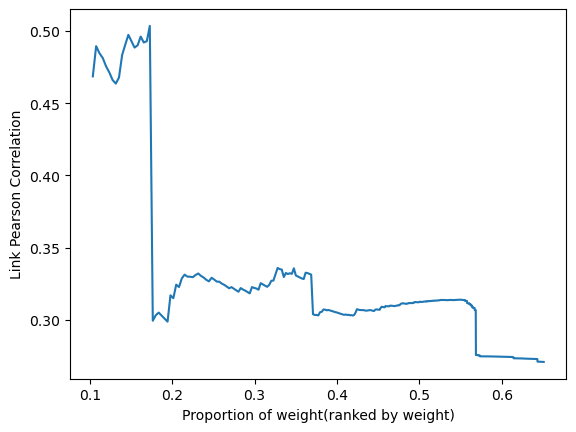

In [85]:
plt.plot(xs, PearsonRankedScores)
plt.xlabel("Proportion of weight(ranked by weight)")
plt.ylabel("Link Pearson Correlation")

In [86]:
fileName= f"{paras.modelLoad}/{paras.modelLoad}_{paras.epi}_{paras.strains}_{paras.n}_{paras.seed}" #SARS_H1N1_COVID
print(fileName)#h1N1: 998, 
np.savez("results/"+fileName+".npz", A= AdjCurTen.cpu().detach(), Apre= PreA.cpu().detach(),
         loss= losses, tausP= myEpi.taus.cpu().detach(), 
         r0sP= (myEpi.R0dTaus*myEpi.taus).cpu().detach(), signal= signal.cpu().detach(), predSignal= predSignal.cpu().detach())

AA/AA_ALL__3_93_1018


In [311]:
# # Epi= "H1N1"
# # paras.n= 21
# seed= 998
# fileName= f"{paras.modelLoad}/{paras.modelLoad}_{paras.epi}_{paras.strains}_{paras.n}_{seed}" #SARS_H1N1_COVID
# # fileName= "AA/AA_SARS_H1N1_COVID_3_93" 
# #1, 10, 20, 30, 40, 50
# npzfile = np.load("results/"+fileName+".npz")
# PreA= torch.tensor(npzfile["Apre"]).to(device= device)
# AdjCurTen= torch.tensor(npzfile["A"]).to(device= device)
# signal= torch.tensor(npzfile["signal"])
# predSignal= torch.tensor(npzfile["predSignal"])

# errorTmp= myloss(predSignal[:, :, 0:-1] ,signal[:, :, 1:])

# print(errorTmp)

In [21]:
seeds= [999, 1000, 1001, 1002, 1003]
preAs= []
sumPreA= 0
for seed in seeds:
    fileName= f"{paras.modelLoad}/{paras.modelLoad}_{paras.epi}_{1}_{40}_{seed}" #SARS_H1N1_COVID
    npzfile = np.load("results/"+fileName+".npz")
    PreA= torch.tensor(npzfile["Apre"]).to(device= device)
    sumPreA+= PreA
    AdjCurTen= torch.tensor(npzfile["A"]).to(device= device)
    signal= torch.tensor(npzfile["signal"]).to(device= device)
    predSignal= torch.tensor(npzfile["predSignal"]).to(device= device)
    errorTmp= myloss(predSignal[:, :, 0:-1] ,signal[:, :, 1:])
    # print(errorTmp)
    preAs.append(PreA)
sumPreA= sumPreA/len(seeds)
preAs.append(sumPreA)
preAs.append(AdjCurTen)
for i in preAs:
    for j in preAs:
        print(np.round(evaluate.pearson_correlation(i, j).item(),2), end= ", ")
    print()

1.0, 0.57, 0.52, 0.29, 0.3, 0.71, 0.08, 
0.57, 1.0, 0.98, 0.27, 0.29, 0.82, 0.05, 
0.52, 0.98, 1.0, 0.28, 0.3, 0.81, 0.05, 
0.29, 0.27, 0.28, 1.0, 0.96, 0.73, 0.08, 
0.3, 0.29, 0.3, 0.96, 1.0, 0.75, 0.08, 
0.71, 0.82, 0.81, 0.73, 0.75, 1.0, 0.09, 
0.08, 0.05, 0.05, 0.08, 0.08, 0.09, 1.0, 
